Simple Vanilla Neural Net 

#### PROJECT ROADMAP TO-DOs

- [] Flush out deep NN model, try adding 3-5 *layers*, and experiment with different sizes of those layers. Take it to the extremes, and try adding ~10+ layers to see how that changes the model.

- [ ] Graph out accuracies of shallow AND deep models 

- [x] Explore the ideas of precision / recall, F1 score (read up about this). Write functions to calculate precision() and recall() for your models. Run these functions on ShallowNN, Logistic model, and DeepNN. Write function to compute F1 score -- compute_f1_score(), and run the same tests.

- [] Tune and *graph* different hyper-parameter experiments (lr, epoch, etc). 

- [] Try training on another data set (this can be another image set OR non-image data) 

In [88]:
#Image classifer with logistic regression
#images shape(width,height,3(rgb))

###to knit to html ipython nbconvert --to html [NEWFILENAME].html
import numpy as np
import scipy 
import os
import matplotlib.pyplot as plt
import math
from scipy import ndimage
from skimage import io
from PIL import Image
import sys
#from basicFunctions import crossEntropyLoss 
 

In [57]:
# Global Constants
side_length = 100
image_path = "../Data/Logistic_Regression_Data/"
test_ratio = .3
epoch = 7000
learning_rate = .2
max_num_images = 300

In [3]:
def getImageArrays(path, side_length): #returns list of images arrays for a specified path
    image_names = os.listdir(path)
    image_names = image_names[:max_num_images]
    examples = []
    for image_name in image_names:
        if image_name.split(".")[-1] != "DS_Store":
            try:
                cur_image_path = path + image_name
                cur_image = np.array(ndimage.imread(cur_image_path,flatten=False))
                cur_array_resized = scipy.misc.imresize(cur_image,size=(side_length,side_length))
                cur_array_flattened = cur_array_resized.reshape((side_length*side_length*3)).T

                examples += [cur_array_flattened] 
            except ValueError:
                print("Error in creating examples",image_name)
                
    return examples

In [4]:
#create examples & labels
cow_images_path = image_path + "cows/"
notCow_image_path = image_path + "notcows/"

examples_cow = getImageArrays(cow_images_path, side_length)
labels_cow = np.ones(len(examples_cow))
examples_notCow = getImageArrays(notCow_image_path, side_length)
labels_notCow = np.zeros(len(examples_notCow))

examples_cow = np.array(examples_cow)
examples_notCow = np.array(examples_notCow)
#assert(examples_cow.shape[1:] == (side_length,side_length,3)), "examples_cow are invalid shape"
examples = np.concatenate((examples_cow,examples_notCow))
labels = np.concatenate((labels_cow,labels_notCow))
print("Number of Examples:",len(examples))
print("Number of Labels:",len(labels))


Error in creating examples notcow197.jpg
Error in creating examples notcow20.jpg
Number of Examples: 596
Number of Labels: 596


In [5]:
shuffled_indexing = np.random.permutation(labels.shape[0])
examples = examples[shuffled_indexing]
labels = labels[shuffled_indexing]

In [6]:
#seperate train and test examples
number_examples_test = int(len(examples)*test_ratio)
number_labels_test = int(len(labels)*test_ratio)

examples_test = examples[:number_examples_test]
examples_train = examples[number_examples_test:]
labels_test = labels[:number_labels_test]
labels_train = labels[number_labels_test:]
print("Number of training examples: ", examples_train.T.shape)
print("Number of test examples: ", examples_test.T.shape)
print(labels_train.shape)

Number of training examples:  (30000, 418)
Number of test examples:  (30000, 178)
(418,)


In [7]:
#reshape labels for future matrix operations
labels_train = np.reshape(labels_train,(1,len(labels_train)))
labels_test = np.reshape(labels_test,(1,len(labels_test)))

In [8]:
#flatten examples
# flattened_train_examples = examples_train.reshape(examples_train.shape[0], -1).T
# flattened_test_examples = examples_test.reshape(examples_test.shape[0], -1).T  
# print("flattened examples",flattened_test_examples.shape,flattened_train_examples.shape)
flattened_train_examples = examples_train.T
flattened_test_examples = examples_test.T

In [9]:
# Standardize color values of the image (decrease computational cost durring cross entropy)
standardized_train_examples = flattened_train_examples/255 #225 is the maximum rgb value/ This is done to decrease varaince in inputs thus more efficint
standardized_test_examples = flattened_test_examples/255
print("standardized",standardized_test_examples.shape,standardized_train_examples.shape)

standardized (30000, 178) (30000, 418)


In [10]:
def crossEntropyLoss(a,Y):
    num_of_examples = Y.shape[1] #len(Y) doesn't work, need 2nd dimesnion
    a = a.T
    loss = - (1.0 / num_of_examples) * (np.dot((1.0 - Y), np.log(1.0 - a)) + np.dot(Y, np.log(a)))
    return loss

In [11]:
def sigmoid(x):
    output = 1.0/(1.0+np.exp(-x))
    cached_value = x
    cached_value = {"out_a":x}
    return output, cached_value

In [12]:
def relu(x,leaky=0):
    output = np.maximum(leaky,x)
#     cached_value = x
    cached_value = {"out_a":x}
    return output, cached_value
    

In [13]:
def initialize_params_shallow(input_layer, hidden_layer, output_layer):
    w1 = np.random.randn(hidden_layer,input_layer)
    w2 = np.random.randn(output_layer,hidden_layer)
    #np.random.randn gives numbers larger than 1 so: (vanishing/exploading gradients)
    w1,w2 = w1 * .01, w2 * .01
    
    #is it by one because of broadcasting 
    b1 = np.zeros((hidden_layer,1))
    b2 = np.zeros((output_layer,1))
    
    assert(w1.shape == (hidden_layer, input_layer))
    assert(w2.shape == (output_layer, hidden_layer))
    assert(b1.shape == (hidden_layer,1))
    assert(b2.shape == (output_layer,1))
    
    return {"w1":w1,"w2":w2,"b1":b1,"b2":b2}

In [14]:
def initialize_params_deep(input_layer, hidden_layers, output_layer):
#     np.random.seed(3) #non random random numbers (will get the same random numbers each time) used for testing
    layers = {} #dictionary of weights and biasis
    previous_layer = input_layer #sets the begining shape as shape of input layer
    for i in range(len(hidden_layers)):
        cur_layer = hidden_layers[i]
        weights = np.random.randn(cur_layer,previous_layer)
        weights *= .01 #because np.random.rand returns numbers too large, more efficeint durring gradient descensed 
        bias = np.zeros((cur_layer,1))
        cur_weights_key = "w" + str(i + 1) # i + 1 because humans like things indexed at 0
        cur_bias_key = "b" + str(i + 1)
        layers[cur_weights_key] = weights
        layers[cur_bias_key] = bias 
        
        assert(layers["w" + str(i + 1)].shape == (cur_layer, previous_layer))
        assert(layers["b" + str(i + 1)].shape == (cur_layer,1))
        
        previous_layer = cur_layer

    layers["w" + str(len(hidden_layers) + 1)] = np.random.randn(output_layer,previous_layer) * .01
    layers["b" + str(len(hidden_layers) + 1)] = np.zeros((output_layer,1))

    return layers

In [15]:
def linear_forward_prop(a,w,b): #a because a is from the past layer
#     print("Before Transpose -- A:",a.shape,"W:",w.shape,"B:",b.shape)
#     print("After Transpose -- A:",a.shape,"W:",w.shape,"B:",b.shape)
    z = np.dot(w,a) + b
#     print("z:",z.shape)
#     print("z",z.shape,"a",a.shape[0],"w",w.shape[1],"b",b.shape)
#     assert(z.shape == (a.shape[0], w.shape[1] ))
    #     assert(z.shape == np.dot(a,w).shape)
    cached_inputs = {"in_a":a,"w":w,"b":b,"z":z} #(a,w,b)
    return z,cached_inputs
    

In [16]:
def singleFowardPropagation(X,w,b,activationType,leaky=0): #TODO change x to a
#     cached_inputs = {"w":None,"x":None,"b":None,"z":None}
    z,cached_values = linear_forward_prop(X,w,b)
    if activationType == "sigmoid":
        a, activation_cache = sigmoid(z)
    if activationType == "relu":
        a, activation_cache = relu(z,leaky=leaky)
    cached_values.update(activation_cache)
    return a, cached_values

In [17]:
def fowardPropagate(X,params):
    num_layers = len(params) // 2 #// rounds down
    #assert len params is even
    a = X
    cached_values = []
    for i in range(1,num_layers):
        w = params["w" + str(i)]
        b = params["b" + str(i)]
        past_a = a
        a, cur_cached = singleFowardPropagation(past_a,w,b,"relu")
        cached_values += [cur_cached] #TODO: get foramt of cached values 
        
    w = params["w" + str(num_layers)]
    b = params["b" + str(num_layers)]
    a, cur_cached = singleFowardPropagation(a,w,b,"sigmoid")
    cached_values += [cur_cached] 
    #write assert statemt here
    return a, cached_values

In [18]:
def linearBackprop(cached_values, dZ):
    a = cached_values["in_a"]
    w = cached_values["w"]
    b = cached_values["b"]
    number_examples = a.shape[1]
    dW = (1.0/number_examples) * np.dot(dZ,a.T)
    dB = (1.0/number_examples) * np.sum(dZ, axis = 1, keepdims= True)
    dA = np.dot(w.T, dZ)
    return {"dW":dW,"dB":dB,"dA":dA}
    
    

In [19]:
def relu_backward(dA, z):
    dZ = np.array(dA, copy=True) #convert dA to np array
    dZ[z <= 0] = 0
    return dZ
    

In [20]:
def sigmoid_backward(dA, z):
    s = 1/(1 + np.exp(-z))
    dz = dA * s * (1-s) 
    
    return dz

In [21]:
def backwards_activation(dA, cached_values, activation_type):
    if activation_type == "sigmoid":
        dZ = sigmoid_backward(dA, cached_values["z"])
    if activation_type == "relu":
        dZ = relu_backward(dA, cached_values["z"])
    gradients = linearBackprop(cached_values, dZ)
    return gradients
    
    #todo write optimizer function
        
        
    

In [22]:
def backprop(a, cached_values, y):
    gradients = {}
    num_layers = len(cached_values)
    y = y.reshape(a.shape)

    dFinalA = -(np.divide(y,a) - np.divide(1-y, 1-a)) #dervivative of output of foward pass 
    backwards_activation_output_0 = backwards_activation(dFinalA, cached_values[-1],"sigmoid")
    
    gradients["dW" + str(num_layers)] = backwards_activation_output_0["dW"]
    gradients["dB" + str(num_layers)] = backwards_activation_output_0["dB"]
    gradients["dA" + str(num_layers - 1)] = backwards_activation_output_0["dA"]
    
    for i in reversed(range(num_layers - 1)):
        past_layer = cached_values[i]
        cur_dLayer = backwards_activation(gradients["dA" + str(i + 1)], past_layer, "relu")
        gradients["dW" + str(i + 1)] = cur_dLayer["dW"]
        gradients["dB" + str(i + 1)] = cur_dLayer["dB"]
        gradients["dA" + str(i)] = cur_dLayer["dA"]
    return gradients

In [23]:
def optimize(grads,params, learning_rate):
    num_layers = len(params)//2
    for i in range(num_layers): #subtraction
#         print("lr",learning_rate)
#         print("w-before (", str(i+1), "): ", params["w" + str(i +1)])
#         print("b-before (", str(i+1), "): ", params["b" + str(i +1)])
#         print("------------")
#         print("dW",grads["dW" + str(i + 1)])
#         print("dB",grads["dB" + str(i + 1)])
        params["w" + str(i +1)] = params["w" + str(i + 1)] - (grads["dW" + str(i + 1)] * learning_rate)
        params["b" + str(i + 1)] = params["b" + str(i + 1)] - (grads["dB" + str(i + 1)] * learning_rate)
#         print("w-after (", str(i+1), "): ", params["w" + str(i +1)])
#         print("b-after (", str(i+1), "): ", params["b" + str(i +1)])
    return params

In [24]:
input_layer = 12288 #change to side length*length*3 
hidden_layer = 7
output_layer = 1

In [25]:
def shallowNN(X,y,epoch,lr,input_layer,hidden_layer,output_layer):
    params = initialize_params_shallow(input_layer,hidden_layer,output_layer)
    costs = []
    grads = {}
    for i in range(epoch):
        w1 = params["w1"]
        w2 = params["w2"]
        b1 = params["b1"]
        b2 = params["b2"]
        a1, cached_values1 = singleFowardPropagation(X,w1,b1,"relu")
        a2, cached_values2 = singleFowardPropagation(a1,w2,b2,"sigmoid")
        # backwards [end] (1,710) --> (7,710) --> (exmample size,710) [start]
        cost = crossEntropyLoss(a2,y)
        dFinalA = -(np.divide(y,a2) - np.divide(1.0-y, 1.0-a2))
#         print("dfinal a", dFinalA.shape)
        backwards_activation_output_0 = backwards_activation(dFinalA, cached_values2,"sigmoid")
#         print("penultimate activation",np.shape(backwards_activation_output_0["dA"]))
        backwards_activation_output_1 = backwards_activation(backwards_activation_output_0["dA"], cached_values1,"relu")
#         print("last activation",np.shape(backwards_activation_output_1["dA"]))
        grads["dW1"] = backwards_activation_output_1["dW"]
        grads["dW2"] = backwards_activation_output_0["dW"]
        grads["dB1"] = backwards_activation_output_1["dB"]
        grads["dB2"] = backwards_activation_output_0["dB"]
        params = optimize(grads, params, learning_rate)
        
        costs += [cost]
        if i % 100 == 0:
            print("Costs @ " + str(i) + ":",cost)    
    return params, costs

In [26]:
def shallowNNTest(X,y,params):
    w1 = params["w1"]
    w2 = params["w2"]
    b1 = params["b1"]
    b2 = params["b2"]
    a1, cached_values1 = singleFowardPropagation(X,w1,b1,"relu")
    a2, cached_values2 = singleFowardPropagation(a1,w2,b2,"sigmoid")
    loss = 1 - np.mean(np.abs(a2-y))
    print("Test Accuracey:",loss * 100,"%")
    return loss 

In [27]:
X = standardized_train_examples
y = labels_train
input_layer = side_length * side_length * 3
hidden_layer = 7
output_layer = 1
learning_rate = .01
params,costs = shallowNN(X,y,2000,learning_rate,input_layer,hidden_layer,output_layer)

Costs @ 0: [[ 0.69252566]]
Costs @ 100: [[ 0.6403955]]
Costs @ 200: [[ 0.50176175]]
Costs @ 300: [[ 0.4987403]]
Costs @ 400: [[ 0.4446108]]
Costs @ 500: [[ 0.41360502]]
Costs @ 600: [[ 0.40492271]]
Costs @ 700: [[ 0.36510672]]
Costs @ 800: [[ 0.34548186]]
Costs @ 900: [[ 0.30250976]]
Costs @ 1000: [[ 0.20765576]]
Costs @ 1100: [[ 0.17029188]]
Costs @ 1200: [[ 0.14568449]]
Costs @ 1300: [[ 0.12733834]]
Costs @ 1400: [[ 0.10749311]]
Costs @ 1500: [[ 0.0926972]]
Costs @ 1600: [[ 0.10048525]]
Costs @ 1700: [[ 0.07078047]]
Costs @ 1800: [[ 0.05521385]]
Costs @ 1900: [[ 0.04458302]]


In [28]:
X = standardized_test_examples
y = labels_test
loss = shallowNNTest(X,y,params)

Test Accuracey: 73.4149795332 %


In [45]:
def deepNN(X,y,epoch,lr,input_layer,hidden_layers,output_layer):
    params = initialize_params_deep(input_layer,hidden_layers,output_layer)
    costs = []
    print("params",len(params))
    for i in range(epoch):
        a, cache = fowardPropagate(X,params)
        cost = crossEntropyLoss(a,y)
        grads = backprop(a, cache, y)
        params = optimize(grads, params, lr)
        if i % 200 == 0:
            print("Cost @",i,cost)
        costs += [cost]
    return params,costs
            
        
        
        

In [133]:
#works only for binary classification
def precision(preds,y):
    preds = np.abs(np.round(preds))
    p_predict = np.sum(preds) #number of positives 
    tP = np.sum(preds*y)
    return tP/p_predict

def recall(preds,y):
    preds = np.abs(np.round(preds))
    tP = np.sum(preds*y)
    new_preds = np.array(preds)
    new_preds[new_preds == 0] = -1
    #all 0 are now -1 in preds
    product = new_preds * y
    # after multiplying the only -1s left are false negatives
    fN = len(product[product == -1])
    return tP / (tP + fN)

In [135]:
def deepNNEval(X, y, params):
    a, _ = fowardPropagate(X,params)
    loss = np.mean(np.abs(a-y))
    precision_score = precision(a,y)
    recall_score = recall(a,y)
    print("Loss:", loss)
    print("Percision:", precision_score)
    print("Recall:", recall_score)
    return loss, precision_score, recall_score

In [31]:
X = standardized_train_examples
y = labels_train
input_layer = side_length * side_length * 3
hidden_layers = [7, 5]
output_layer = 1
learning_rate = .01
params, costs = deepNN(X,y,5000,learning_rate,input_layer,hidden_layers,output_layer)

Cost @ 0 [[ 0.69314594]]
Cost @ 200 [[ 0.69267378]]
Cost @ 400 [[ 0.69249364]]
Cost @ 600 [[ 0.69241607]]
Cost @ 800 [[ 0.69236703]]
Cost @ 1000 [[ 0.69230957]]
Cost @ 1200 [[ 0.69220046]]
Cost @ 1400 [[ 0.69191943]]
Cost @ 1600 [[ 0.69091971]]
Cost @ 1800 [[ 0.68572704]]
Cost @ 2000 [[ 0.65553093]]
Cost @ 2200 [[ 0.58673277]]
Cost @ 2400 [[ 0.48766775]]
Cost @ 2600 [[ 0.41945736]]
Cost @ 2800 [[ 0.3421487]]
Cost @ 3000 [[ 0.28894341]]
Cost @ 3200 [[ 0.22854561]]
Cost @ 3400 [[ 0.75844304]]
Cost @ 3600 [[ 0.13287533]]
Cost @ 3800 [[ 0.11074437]]
Cost @ 4000 [[ 0.06864941]]
Cost @ 4200 [[ 0.05149643]]
Cost @ 4400 [[ 0.03810955]]
Cost @ 4600 [[ 0.02992505]]
Cost @ 4800 [[ 0.02383721]]


In [136]:
X = standardized_test_examples
y = labels_test
loss,_,_ = deepNNEval(X,y,params)

Loss: 0.273606551433
Percision: 0.767676767677
Recall: 0.775510204082


In [33]:
def getImage(image_path,side_length,show=True):
    if (image_path.split(":")[0] == "http") or (image_path.split(":")[0] == "https"):
        try:
            image = io.imread(image_path)
        except:
            print("Sorry, but this url forbids requests from machines :(")
            assert(5 == 4)
    else:
        image = np.array(ndimage.imread(image_path, flatten=False))
    if show == True:
        io.imshow(image)
        io.show()
    array_resized = scipy.misc.imresize(image, size=(side_length,side_length))
    array_flattened = array_resized.reshape((side_length*side_length*3, 1))
    array_standardized = array_flattened/225
    return array_standardized 

In [34]:
def classify(image_path, params):
    side_length = int((params["w1"].shape[1]/3) ** .5)
    image_array = getImage(image_path, side_length)
    label,_ = fowardPropagate(image_array,params)
    if round(label[0][0]) == 1:
        print("Mœ",label[0][0])
    if round(label[0][0]) == 0:
        print("This is not a cow",label[0][0])
    

In [39]:
def plot_costs(run_costs,label=None):
    run_costs = np.array(run_costs) #makes costs one array instead of list of arrays
    run_costs = np.squeeze(run_costs)
    print("Run Costs",run_costs[:20])
    sample_timestep = 1
    x = np.arange(0,len(run_costs),sample_timestep) 
    plt.plot(x, run_costs, label=label)

In [40]:
def compare_runs(train_X,train_Y,test_X,test_Y, run_params, intput_layer): 
    test_losses = []
    for run in run_params:
        cur_learning_rate = run["learning_rate"]
        cur_epoch = run["epoch"]
        cur_hidden = run["hidden"]
        print("Run {epoch: " + str(cur_epoch) + ", lr: " + str(cur_learning_rate) + ", hidden: " + str(cur_hidden) + "}")
        cur_params, cur_costs = deepNN(train_X,train_Y,cur_epoch, cur_learning_rate, input_layer, cur_hidden,1)
        cur_label = "epoch: " + str(cur_epoch) + ", lr: " + str(cur_learning_rate) + ", hidden: " + str(cur_hidden) + ""
        cur_test_loss = deepNNEval(test_X,test_Y,cur_params)
#         print(:cur)
        test_losses += [cur_test_loss]
        plot_costs(cur_costs,cur_label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return test_losses
        

Run {epoch: 100, lr: 0.01, hidden: [10, 20, 4, 8, 3]}
params 12
Cost @ 0 [[ 0.69314718]]
0.50042866861 0.449438202247
Run Costs [ 0.69314718  0.69314352  0.69313988  0.69313625  0.69313265  0.69312906
  0.69312549  0.69312194  0.69311841  0.69311489  0.6931114   0.69310792
  0.69310445  0.69310101  0.69309758  0.69309417  0.69309077  0.69308739
  0.69308403  0.69308069]
Run {epoch: 100, lr: 0.1, hidden: [7, 5, 3]}
params 8
Cost @ 0 [[ 0.69314719]]
0.501781214933 0.449438202247
Run Costs [ 0.69314719  0.69311101  0.69307662  0.69304394  0.69301286  0.69298332
  0.69295524  0.69292855  0.69290317  0.69287905  0.69285611  0.69283431
  0.69281359  0.69279389  0.69277516  0.69275736  0.69274043  0.69272434
  0.69270905  0.69269451]


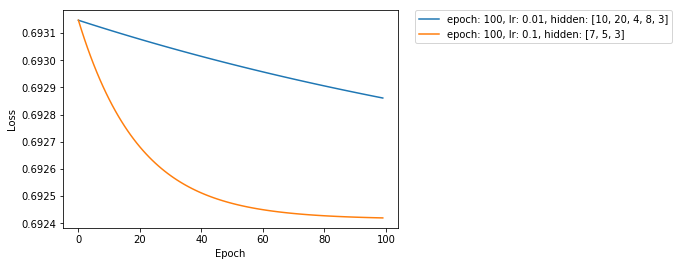

In [46]:
train_X = standardized_train_examples
train_y = labels_train
test_X = standardized_test_examples
test_y = labels_test
run_params = [
    {"learning_rate":.01,"epoch":100,"hidden":[10,20,4,8,3]},
    {"learning_rate":.1,"epoch":100,"hidden":[7,5,3]}
]
input_layer = side_length*side_length*3
losses = compare_runs(train_X, train_y, test_X, test_y, run_params, input_layer)

## 